# Projet Machine Learning - Prédiction du score de Macron aux élections 2022
# UMONS, 2024-2025

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as XGBRegressor
import joblib
import warnings
import os
import glob
import re
from scipy import stats
import matplotlib.ticker as mtick


In [2]:
# Pour ignorer les warnings
warnings.filterwarnings('ignore')

In [3]:

# Configuration pour les graphiques
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("Set2")


In [4]:
# Pour une meilleure lisibilité dans le notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

print("Chargement des bibliothèques terminé")


Chargement des bibliothèques terminé



# 1. CHARGEMENT DES DONNÉES
---


In [6]:
# Définition du chemin des données
data_path = "datasets/"

# Chargement des données d'entraînement et de test
train_data = pd.read_csv(os.path.join(data_path, "results_train.csv"), sep=',', encoding='utf-8')
test_data = pd.read_csv(os.path.join(data_path, "results_test.csv"), sep=',', encoding='utf-8')


In [7]:
# Chargement des données additionnelles
# Niveau de vie
niveau_vie = pd.read_excel(os.path.join(data_path, "Niveau_de_vie_2013_a_la_commune.xlsx"))


In [8]:
# Communes de France
communes_france = pd.read_csv(os.path.join(data_path, "communes-france-2022.csv"), sep=',', encoding='utf-8')


In [9]:
# Données d'âge
age_insee = pd.read_excel(os.path.join(data_path, "age-insee-2020.xlsx"))


In [10]:
# Données diverses INSEE
insee_divers = pd.read_excel(os.path.join(data_path, "MDB-INSEE-V2.xls"))

print("Chargement des données terminé")


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Chargement des données terminé



# 2. EXPLORATION DES DONNÉES (EDA)



## 2.1 Préparation des données pour l'analyse


In [12]:
## Examinons d'abord les données d'entraînement


print("\nExploration des données d'entraînement:")
print(f"Shape: {train_data.shape}")
print(train_data.head())
print(train_data.dtypes)



Exploration des données d'entraînement:
Shape: (20892, 32)
  CodeINSEE Libellé du département Libellé de la commune Etat saisie  \
0     01006                    Ain               Ambléon     Complet   
1     01009                    Ain      Andert-et-Condon     Complet   
2     01010                    Ain             Anglefort     Complet   
3     01011                    Ain              Apremont     Complet   
4     01012                    Ain                 Aranc     Complet   

   Inscrits  Abstentions  % Abs/Ins  Votants  % Vot/Ins  Blancs  % Blancs/Ins  \
0       103           19     18.450       84     81.550      12        11.650   
1       280           73     26.070      207     73.930      22         7.860   
2       792          185     23.360      607     76.640      31         3.910   
3       289           42     14.530      247     85.470      29        10.030   
4       283           76     26.860      207     73.140      28         9.890   

   % Blancs/Vot  Nul

In [13]:
# Variable cible: "% Voix/Ins" pour Macron
# Filtrons pour ne garder que les lignes de Macron
macron_data = train_data[train_data['Nom'] == 'MACRON'].copy()
print(f"\nDonnées Macron uniquement: {macron_data.shape}")


Données Macron uniquement: (20892, 32)


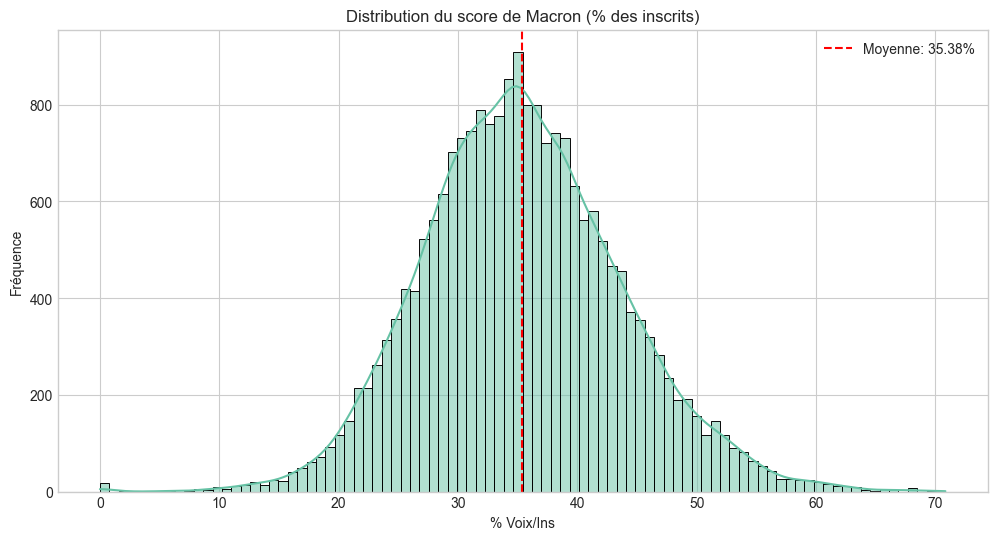

Statistiques descriptives de la variable cible (% Voix/Ins):
count   20892.000
mean       35.381
std         8.320
min         0.000
25%        29.810
50%        35.020
75%        40.650
max        70.830
Name: % Voix/Ins, dtype: float64


In [14]:

# Distribution de la variable cible
plt.figure(figsize=(12, 6))
sns.histplot(macron_data['% Voix/Ins'], kde=True)
plt.title('Distribution du score de Macron (% des inscrits)')
plt.axvline(macron_data['% Voix/Ins'].mean(), color='r', linestyle='--', label=f'Moyenne: {macron_data["% Voix/Ins"].mean():.2f}%')
plt.xlabel('% Voix/Ins')
plt.ylabel('Fréquence')
plt.legend()
plt.savefig('distribution_score_macron.png')
plt.show()

print(f"Statistiques descriptives de la variable cible (% Voix/Ins):")
print(macron_data['% Voix/Ins'].describe())


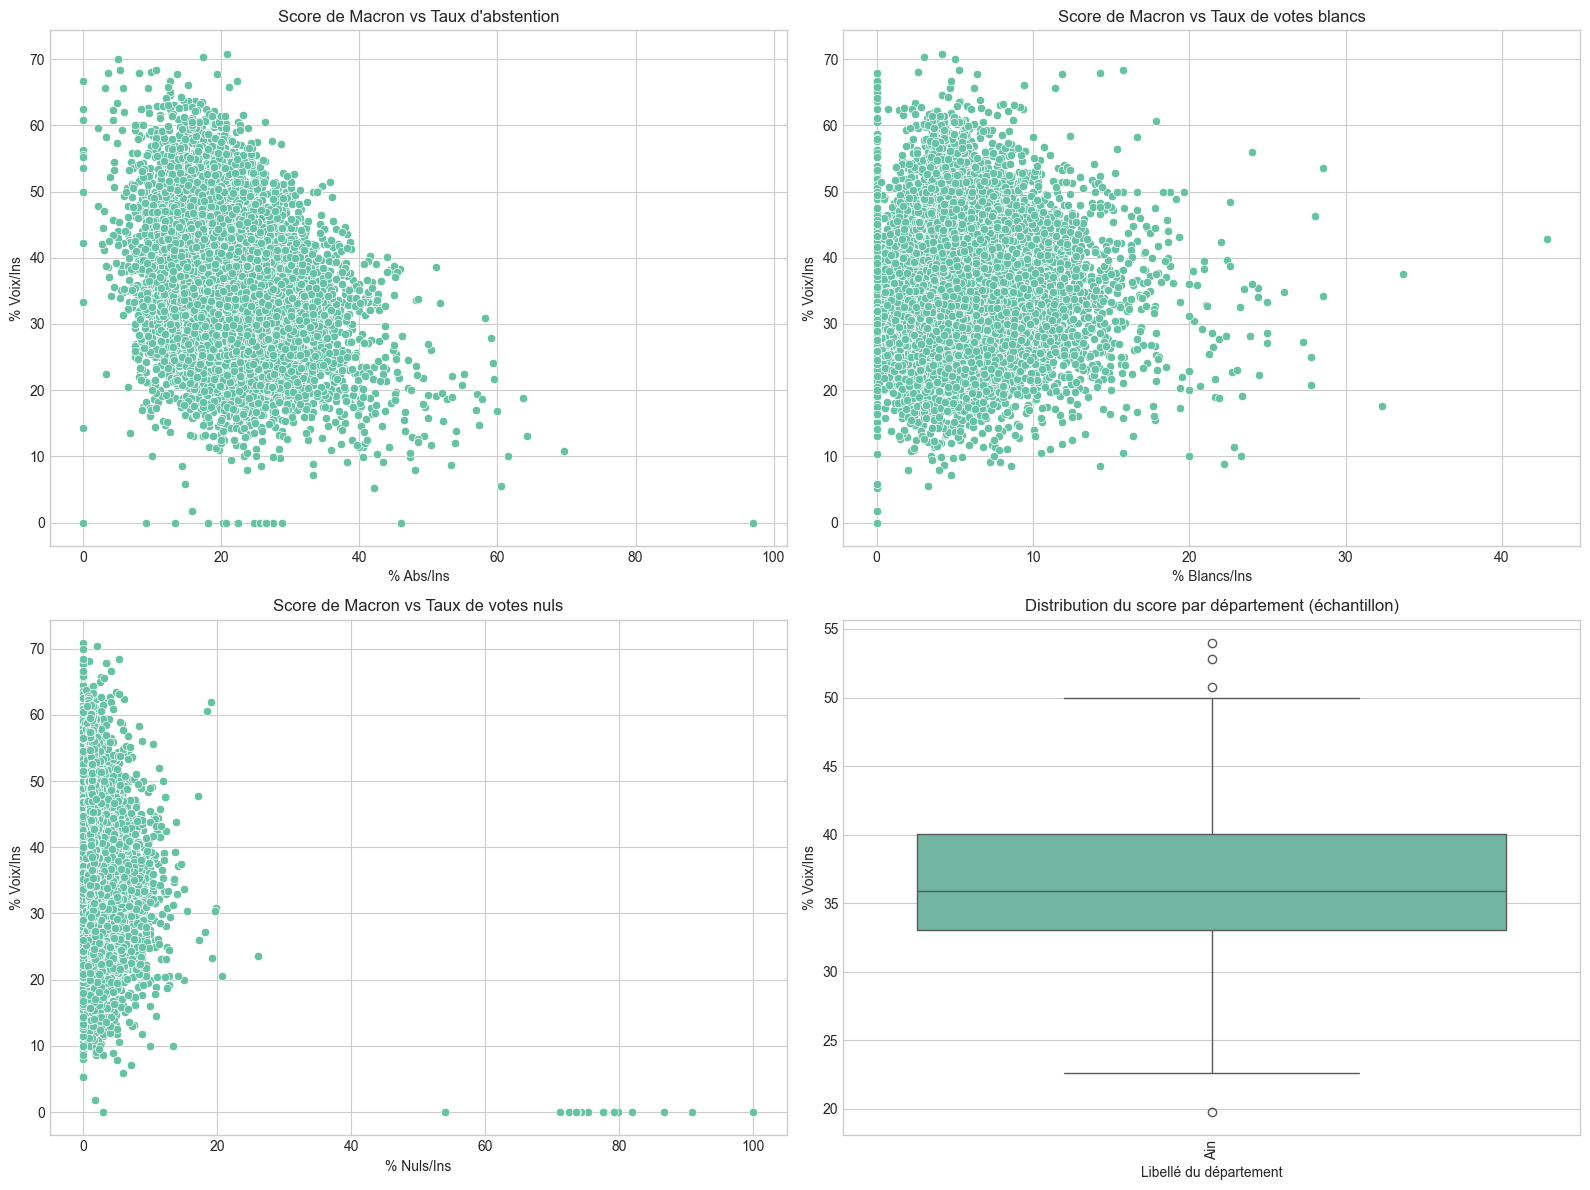

In [15]:
# Explorons la relation entre le pourcentage de voix et d'autres variables
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
sns.scatterplot(x='% Abs/Ins', y='% Voix/Ins', data=macron_data)
plt.title('Score de Macron vs Taux d\'abstention')

plt.subplot(2, 2, 2)
sns.scatterplot(x='% Blancs/Ins', y='% Voix/Ins', data=macron_data)
plt.title('Score de Macron vs Taux de votes blancs')

plt.subplot(2, 2, 3)
sns.scatterplot(x='% Nuls/Ins', y='% Voix/Ins', data=macron_data)
plt.title('Score de Macron vs Taux de votes nuls')

plt.subplot(2, 2, 4)
sns.boxplot(x='Libellé du département', y='% Voix/Ins', data=macron_data.iloc[:200])
plt.title('Distribution du score par département (échantillon)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('relations_variables.png')
plt.show()


## 2.2 Explorons les autres datasets et leur relation avec notre variable cible


### 2.2.1 Nettoyage et préparation des données complémentaires


In [16]:
# Renommons et uniformisons les identifiants des communes pour faciliter la fusion
niveau_vie = niveau_vie.rename(columns={
    'Code Commune': 'CodeINSEE',
    'Nom Commune': 'Commune',
    'Niveau de vie Commune': 'NiveauVieCommune',
    'Niveau de vie Département': 'NiveauVieDepartement'
})


In [17]:

# Assurons-nous que CodeINSEE est au format string
niveau_vie['CodeINSEE'] = niveau_vie['CodeINSEE'].astype(str).str.zfill(5)
macron_data['CodeINSEE'] = macron_data['CodeINSEE'].astype(str).str.zfill(5)
test_data['CodeINSEE'] = test_data['CodeINSEE'].astype(str).str.zfill(5)


In [18]:

# Préparation des données communes France
communes_france['code_insee'] = communes_france['code_insee'].astype(str).str.zfill(5)

# Préparation des données d'âge
age_insee['INSEE'] = age_insee['INSEE'].astype(str).str.zfill(5)

# Préparation des données INSEE diverses
insee_divers['CODGEO'] = insee_divers['CODGEO'].astype(str).str.zfill(5)




### 2.2.2 Fusion des datasets pour l'analyse exploratoire


In [19]:
# Fusionnons les données pour voir les corrélations avec le score de Macron
merged_data = macron_data[['CodeINSEE', '% Voix/Ins', 'Libellé du département']].copy()


In [20]:
# Fusion avec niveau de vie
merged_data = pd.merge(merged_data, niveau_vie, on='CodeINSEE', how='left')


In [21]:
# Fusion avec communes_france (sélection de variables pertinentes)
communes_select = communes_france[['code_insee', 'population', 'superficie_km2', 'densite', 'altitude_moyenne',
                                 'latitude_centre', 'longitude_centre', 'grille_densite']]
merged_data = pd.merge(merged_data, communes_select, left_on='CodeINSEE', right_on='code_insee', how='left')

In [22]:
# Fusion avec age_insee (nous allons créer des variables agrégées)
age_groups = age_insee.copy()
# Création de variables démographiques
age_groups['PctJeunes'] = (age_groups['F0-2'] + age_groups['F3-5'] + age_groups['F6-10'] + age_groups['F11-17'] +
                          age_groups['H0-2'] + age_groups['H3-5'] + age_groups['H6-10'] + age_groups['H11-17']) / \
                         (age_groups.iloc[:, 5:].sum(axis=1)) * 100
age_groups['PctAdultes'] = (age_groups['F18-24'] + age_groups['F25-39'] + age_groups['F40-54'] +
                           age_groups['H18-24'] + age_groups['H25-39'] + age_groups['H40-54']) / \
                          (age_groups.iloc[:, 5:].sum(axis=1)) * 100
age_groups['PctSeniors'] = (age_groups['F55-64'] + age_groups['F65-79'] + age_groups['F80+'] +
                           age_groups['H55-64'] + age_groups['H65-79'] + age_groups['H80+']) / \
                          (age_groups.iloc[:, 5:].sum(axis=1)) * 100
age_groups['RatioFH'] = age_groups.iloc[:, 5:15].sum(axis=1) / age_groups.iloc[:, 15:].sum(axis=1)

age_select = age_groups[['INSEE', 'PctJeunes', 'PctAdultes', 'PctSeniors', 'RatioFH']]
merged_data = pd.merge(merged_data, age_select, left_on='CodeINSEE', right_on='INSEE', how='left')


In [23]:
# Fusion avec insee_divers (sélection de variables pertinentes)
insee_select = insee_divers[['CODGEO', 'Moyenne Revenus Fiscaux Départementaux', 'Moyenne Revnus fiscaux',
                           'Urbanité Ruralité', 'Taux Propriété', 'Orientation Economique', 'Dynamique Démographique INSEE']]
merged_data = pd.merge(merged_data, insee_select, left_on='CodeINSEE', right_on='CODGEO', how='left')



### 2.2.3 Analyse des corrélations


In [24]:
print("\nAnalyse des corrélations avec le score de Macron:")



Analyse des corrélations avec le score de Macron:


In [25]:

# Sélection des variables numériques pour la matrice de corrélation
numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr_matrix = merged_data[numeric_cols].corr()


In [26]:

# Affichage des corrélations les plus fortes avec la variable cible
corr_with_target = corr_matrix['% Voix/Ins'].sort_values(ascending=False)
print(corr_with_target)


% Voix/Ins                                1.000
NiveauVieCommune                          0.426
NiveauVieDepartement                      0.245
Moyenne Revnus fiscaux                    0.193
RatioFH                                   0.155
Moyenne Revenus Fiscaux Départementaux    0.144
densite                                   0.125
population                                0.078
PctSeniors                                0.073
Taux Propriété                            0.067
PctAdultes                                0.035
PctJeunes                                 0.017
altitude_moyenne                          0.005
superficie_km2                            0.004
latitude_centre                          -0.044
Dynamique Démographique INSEE            -0.081
longitude_centre                         -0.252
Name: % Voix/Ins, dtype: float64


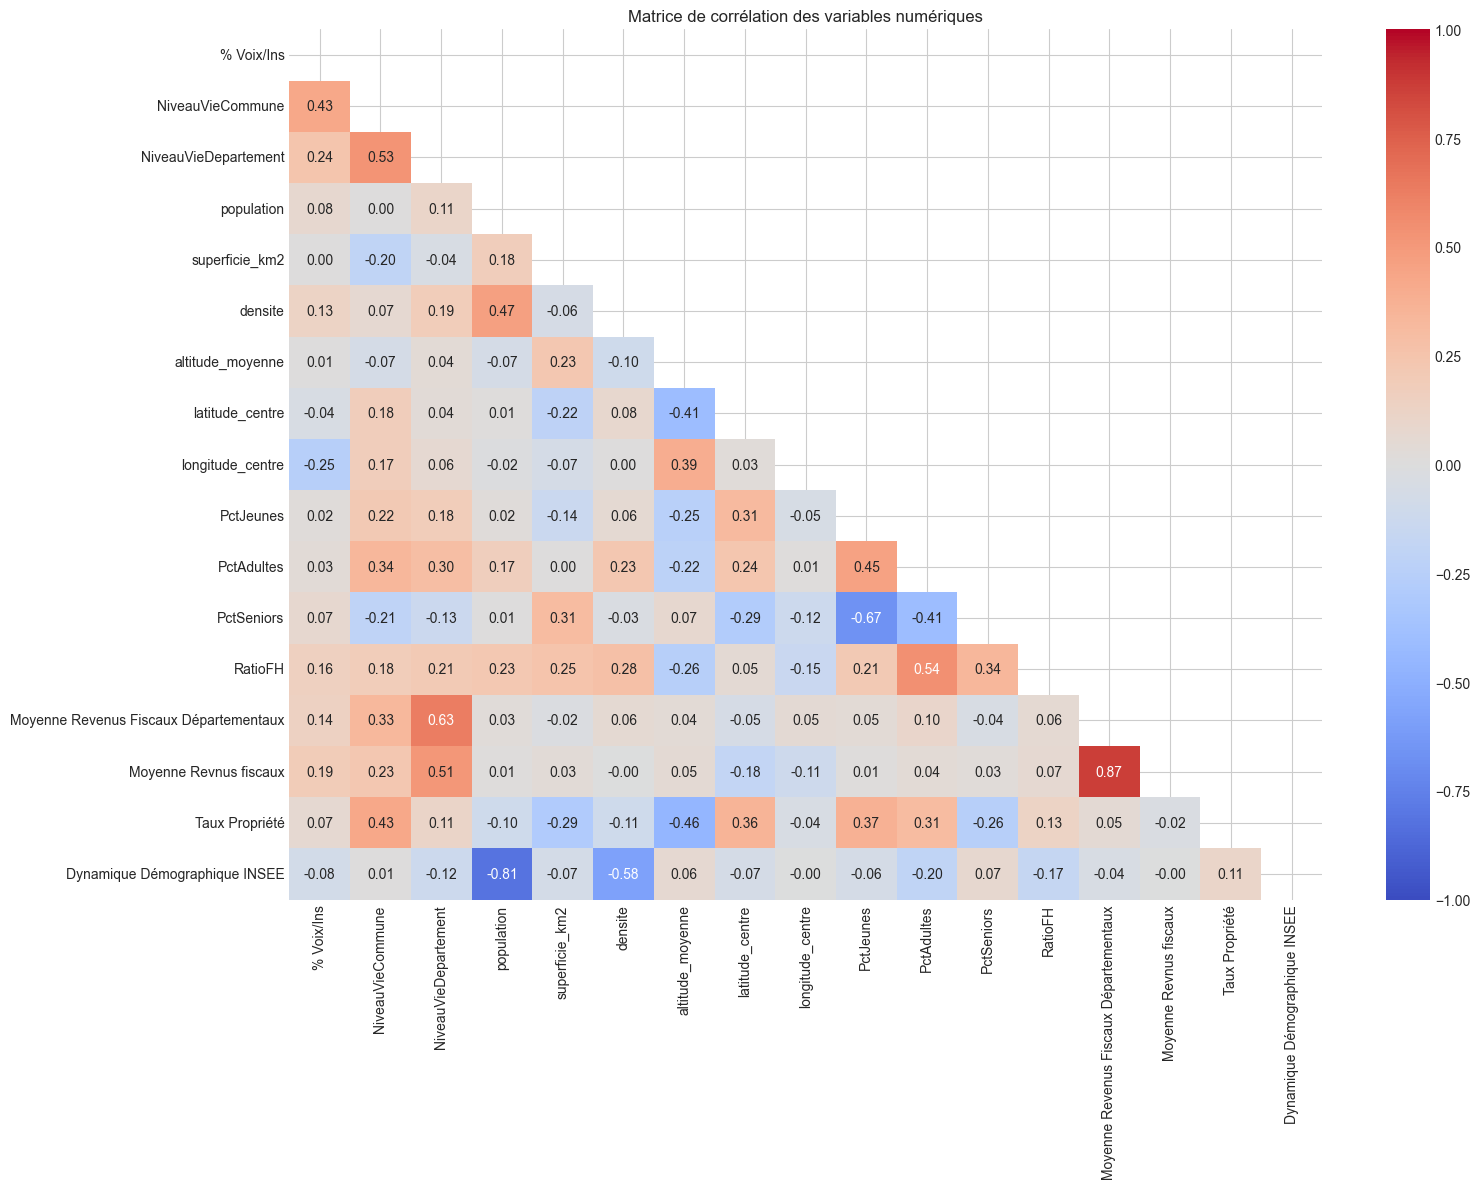

In [27]:
# Visualisation de la matrice de corrélation
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()


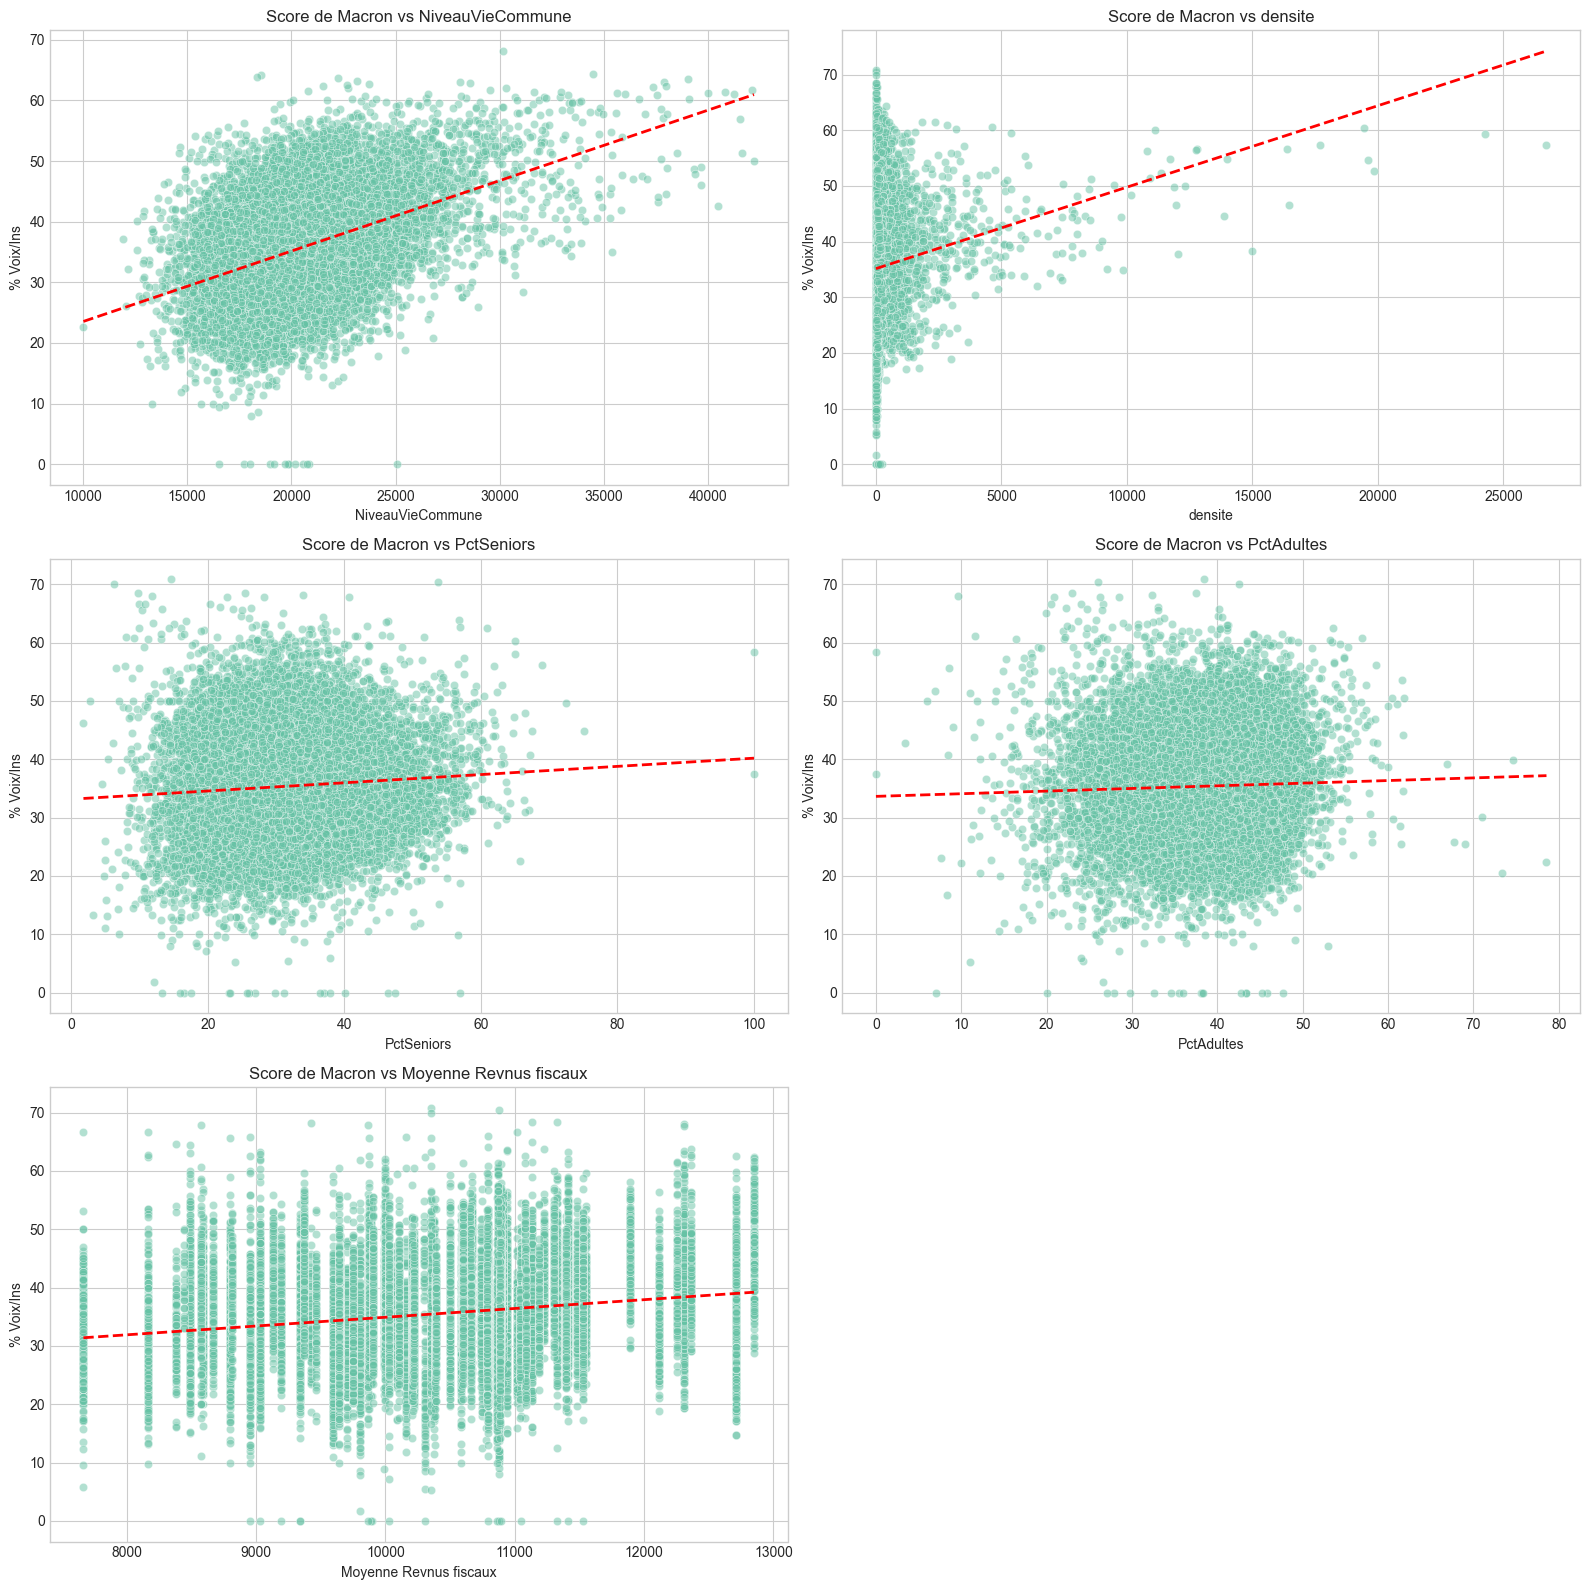

In [28]:
# Visualisation des relations entre variables importantes et score de Macron
plt.figure(figsize=(16, 16))
important_features = ['NiveauVieCommune', 'densite', 'PctSeniors', 'PctAdultes', 'Moyenne Revnus fiscaux']

for i, feature in enumerate(important_features):
    plt.subplot(3, 2, i+1)
    sns.scatterplot(x=feature, y='% Voix/Ins', data=merged_data, alpha=0.5)
    plt.title(f'Score de Macron vs {feature}')
    try:
        z = np.polyfit(merged_data[feature].dropna(), merged_data.loc[merged_data[feature].notna(), '% Voix/Ins'], 1)
        p = np.poly1d(z)
        plt.plot(sorted(merged_data[feature].dropna()), p(sorted(merged_data[feature].dropna())), "r--", linewidth=2)
    except:
        pass

plt.tight_layout()
plt.savefig('important_features.png')
plt.show()



### 2.2.4. Analyse des variables catégorielles


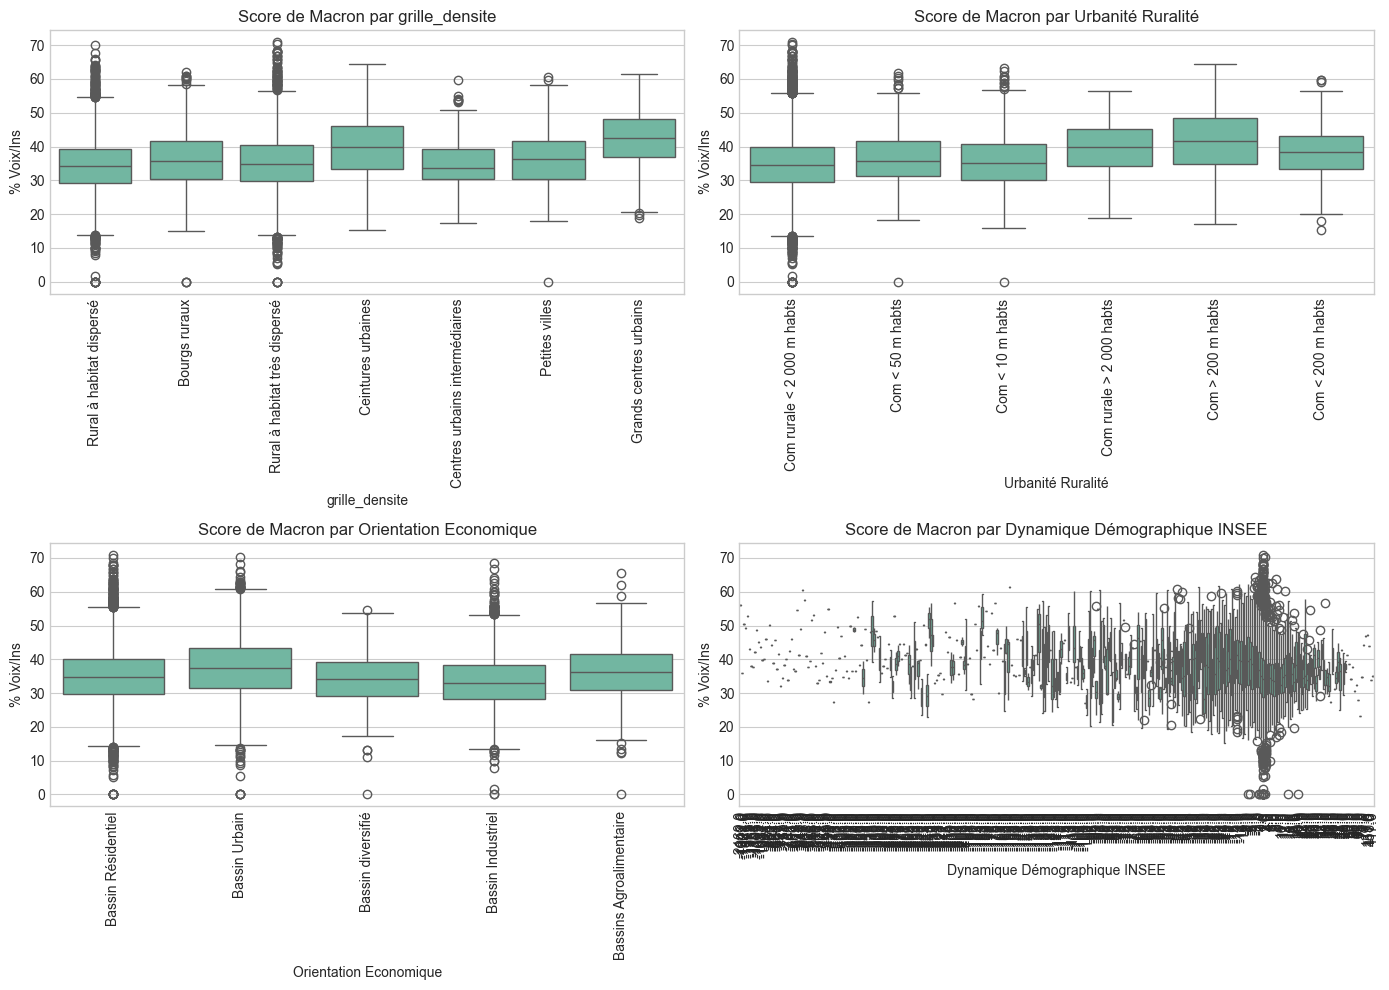

In [29]:
plt.figure(figsize=(14, 10))
cat_vars = ['grille_densite', 'Urbanité Ruralité', 'Orientation Economique', 'Dynamique Démographique INSEE']

for i, var in enumerate(cat_vars):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=var, y='% Voix/Ins', data=merged_data)
    plt.title(f'Score de Macron par {var}')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('categorical_analysis.png')
plt.show()

In [30]:

print("\nRésumé des données manquantes par colonne:")
print(merged_data.isnull().sum().sort_values(ascending=False))



Résumé des données manquantes par colonne:
NiveauVieCommune                          2067
latitude_centre                             18
longitude_centre                            18
PctSeniors                                  14
RatioFH                                     14
PctAdultes                                  14
INSEE                                       14
grille_densite                              14
PctJeunes                                   14
Urbanité Ruralité                           11
Orientation Economique                      11
CODGEO                                      11
Moyenne Revenus Fiscaux Départementaux      11
Moyenne Revnus fiscaux                      11
Dynamique Démographique INSEE               11
Taux Propriété                              11
Commune                                      3
NiveauVieDepartement                         3
densite                                      0
superficie_km2                               0
population      


# 3. PRÉTRAITEMENT DES DONNÉES



## 3.1 Préparation des données pour la modélisation


### Fusionnons tous les datasets pour créer nos features


In [31]:
def prepare_datasets(train_data, test_data, niveau_vie, communes_france, age_insee, insee_divers):
    """
    Fonction pour préparer et fusionner les datasets pour la modélisation
    """
    # Extraction des données de Macron uniquement pour l'entraînement
    train_macron = train_data[train_data['Nom'] == 'MACRON'].copy()

    # Sélection des colonnes pertinentes pour l'entraînement
    train_features = train_macron[['CodeINSEE', '% Voix/Ins', 'Inscrits', 'Abstentions', '% Abs/Ins',
                                 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot',
                                 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot',
                                 'Libellé du département']].copy()

    # Préparation des features pour le test
    test_features = test_data[['CodeINSEE', 'Inscrits', 'Libellé du département']].copy()

    # Assurer que CodeINSEE est au format string avec padding
    train_features['CodeINSEE'] = train_features['CodeINSEE'].astype(str).str.zfill(5)
    test_features['CodeINSEE'] = test_features['CodeINSEE'].astype(str).str.zfill(5)
    niveau_vie['CodeINSEE'] = niveau_vie['CodeINSEE'].astype(str).str.zfill(5)
    communes_france['code_insee'] = communes_france['code_insee'].astype(str).str.zfill(5)
    age_insee['INSEE'] = age_insee['INSEE'].astype(str).str.zfill(5)
    insee_divers['CODGEO'] = insee_divers['CODGEO'].astype(str).str.zfill(5)

    # Fusion avec niveau de vie
    train_features = pd.merge(train_features, niveau_vie, on='CodeINSEE', how='left')
    test_features = pd.merge(test_features, niveau_vie, on='CodeINSEE', how='left')

    # Fusion avec communes_france
    communes_select = communes_france[['code_insee', 'population', 'superficie_km2', 'densite', 'altitude_moyenne',
                                     'latitude_centre', 'longitude_centre', 'grille_densite']]
    train_features = pd.merge(train_features, communes_select, left_on='CodeINSEE', right_on='code_insee', how='left')
    test_features = pd.merge(test_features, communes_select, left_on='CodeINSEE', right_on='code_insee', how='left')

    # Préparation et fusion avec age_insee
    age_groups = age_insee.copy()
    # Création de variables démographiques
    age_groups['PctJeunes'] = (age_groups['F0-2'] + age_groups['F3-5'] + age_groups['F6-10'] + age_groups['F11-17'] +
                              age_groups['H0-2'] + age_groups['H3-5'] + age_groups['H6-10'] + age_groups['H11-17']) / \
                             (age_groups.iloc[:, 5:].sum(axis=1)) * 100
    age_groups['PctAdultes'] = (age_groups['F18-24'] + age_groups['F25-39'] + age_groups['F40-54'] +
                               age_groups['H18-24'] + age_groups['H25-39'] + age_groups['H40-54']) / \
                              (age_groups.iloc[:, 5:].sum(axis=1)) * 100
    age_groups['PctSeniors'] = (age_groups['F55-64'] + age_groups['F65-79'] + age_groups['F80+'] +
                               age_groups['H55-64'] + age_groups['H65-79'] + age_groups['H80+']) / \
                              (age_groups.iloc[:, 5:].sum(axis=1)) * 100
    age_groups['RatioFH'] = age_groups.iloc[:, 5:15].sum(axis=1) / age_groups.iloc[:, 15:].sum(axis=1)
    age_groups['PctJeunes18_24'] = (age_groups['F18-24'] + age_groups['H18-24']) / (age_groups.iloc[:, 5:].sum(axis=1)) * 100
    age_groups['PctAdultes25_39'] = (age_groups['F25-39'] + age_groups['H25-39']) / (age_groups.iloc[:, 5:].sum(axis=1)) * 100
    age_groups['PctAdultes40_54'] = (age_groups['F40-54'] + age_groups['H40-54']) / (age_groups.iloc[:, 5:].sum(axis=1)) * 100
    age_groups['PctSeniors55_64'] = (age_groups['F55-64'] + age_groups['H55-64']) / (age_groups.iloc[:, 5:].sum(axis=1)) * 100
    age_groups['PctSeniors65_79'] = (age_groups['F65-79'] + age_groups['H65-79']) / (age_groups.iloc[:, 5:].sum(axis=1)) * 100
    age_groups['PctSeniors80plus'] = (age_groups['F80+'] + age_groups['H80+']) / (age_groups.iloc[:, 5:].sum(axis=1)) * 100

    age_select = age_groups[['INSEE', 'PctJeunes', 'PctAdultes', 'PctSeniors', 'RatioFH',
                            'PctJeunes18_24', 'PctAdultes25_39', 'PctAdultes40_54',
                            'PctSeniors55_64', 'PctSeniors65_79', 'PctSeniors80plus']]
    train_features = pd.merge(train_features, age_select, left_on='CodeINSEE', right_on='INSEE', how='left')
    test_features = pd.merge(test_features, age_select, left_on='CodeINSEE', right_on='INSEE', how='left')

    # Fusion avec insee_divers
    insee_select = insee_divers[['CODGEO', 'Moyenne Revenus Fiscaux Départementaux', 'Moyenne Revnus fiscaux',
                               'Urbanité Ruralité', 'Taux Propriété', 'Orientation Economique',
                               'Dynamique Démographique INSEE', 'Nb Entreprises Secteur Services',
                               'Nb Entreprises Secteur Commerce', 'Nb Entreprises Secteur Construction',
                               'Nb Entreprises Secteur Industrie', 'Taux étudiants', 'Score Urbanité',
                               'Capacité Fiscale', 'Evolution Population']]
    train_features = pd.merge(train_features, insee_select, left_on='CodeINSEE', right_on='CODGEO', how='left')
    test_features = pd.merge(test_features, insee_select, left_on='CodeINSEE', right_on='CODGEO', how='left')

    # Extraction de la variable cible
    y_train = train_features['% Voix/Ins'].copy()

    # Création d'une feature d'urbanité basée sur la densité
    train_features['log_densite'] = np.log1p(train_features['densite'])
    test_features['log_densite'] = np.log1p(test_features['densite'])

    # Création d'une catégorie de taille de commune
    def categorize_population(pop):
        if pd.isna(pop): return "Unknown"
        elif pop < 500: return "Très petite"
        elif pop < 2000: return "Petite"
        elif pop < 10000: return "Moyenne"
        elif pop < 50000: return "Grande"
        else: return "Très grande"

    train_features['taille_commune'] = train_features['population'].apply(categorize_population)
    test_features['taille_commune'] = test_features['population'].apply(categorize_population)

    # Extraction du département à partir du code INSEE
    train_features['departement'] = train_features['CodeINSEE'].str[:2]
    test_features['departement'] = test_features['CodeINSEE'].str[:2]

    # Calcul du ratio entreprises par habitant
    for df in [train_features, test_features]:
        total_entreprises = df['Nb Entreprises Secteur Services'].fillna(0) + \
                           df['Nb Entreprises Secteur Commerce'].fillna(0) + \
                           df['Nb Entreprises Secteur Construction'].fillna(0) + \
                           df['Nb Entreprises Secteur Industrie'].fillna(0)
        df['ratio_entreprises_pop'] = total_entreprises / df['population'].replace(0, np.nan)

        # Ratio services/industries
        services = df['Nb Entreprises Secteur Services'].fillna(0)
        industries = df['Nb Entreprises Secteur Industrie'].fillna(0)
        df['ratio_services_industries'] = services / industries.replace(0, np.nan)

    # Suppression des colonnes dupliquées ou inutiles pour la modélisation
    drop_cols = ['INSEE', 'code_insee', 'CODGEO', 'Commune']
    train_features = train_features.drop([col for col in drop_cols if col in train_features.columns], axis=1)
    test_features = test_features.drop([col for col in drop_cols if col in test_features.columns], axis=1)

    return train_features, y_train, test_features




### Préparation des données


In [32]:
train_features, y_train, test_features = prepare_datasets(
    train_data, test_data, niveau_vie, communes_france, age_insee, insee_divers
)


In [33]:
print("\nDimensions des features d'entraînement:", train_features.shape)
print("Dimensions des features de test:", test_features.shape)



Dimensions des features d'entraînement: (20892, 55)
Dimensions des features de test: (13928, 41)



### Vérification des données manquantes


In [34]:
missing_train = train_features.isnull().sum() / len(train_features) * 100
missing_test = test_features.isnull().sum() / len(test_features) * 100

print("\nPourcentage de données manquantes (train):")
print(missing_train[missing_train > 0].sort_values(ascending=False))

print("\nPourcentage de données manquantes (test):")
print(missing_test[missing_test > 0].sort_values(ascending=False))



Pourcentage de données manquantes (train):
ratio_services_industries                18.232
NiveauVieCommune                          9.894
longitude_centre                          0.086
latitude_centre                           0.086
PctJeunes                                 0.067
grille_densite                            0.067
PctAdultes25_39                           0.067
PctSeniors                                0.067
RatioFH                                   0.067
PctJeunes18_24                            0.067
PctSeniors55_64                           0.067
PctAdultes40_54                           0.067
PctSeniors65_79                           0.067
PctAdultes                                0.067
PctSeniors80plus                          0.067
Nb Entreprises Secteur Construction       0.057
Nb Entreprises Secteur Commerce           0.057
Nb Entreprises Secteur Services           0.057
Nb Entreprises Secteur Industrie          0.057
Dynamique Démographique INSEE             0.


## 3.2 Séparation des sets d'entraînement et de validation


In [35]:
X_train, X_val, y_train_split, y_val = train_test_split(
    train_features, y_train, test_size=0.2, random_state=42
)

print(f"\nDimensions du set d'entraînement: {X_train.shape}")
print(f"Dimensions du set de validation: {X_val.shape}")



Dimensions du set d'entraînement: (16713, 55)
Dimensions du set de validation: (4179, 55)



## 3.3 Préparation des pipelines pour le prétraitement

### Identifier les colonnes numériques et catégorielles


In [36]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()



### Supprimer 'CodeINSEE' des features car c'est un identifiant


In [38]:
if 'CodeINSEE' in numeric_features:
    numeric_features.remove('CodeINSEE')
if 'CodeINSEE' in categorical_features:
    categorical_features.remove('CodeINSEE')

print(f"\nNombre de features numériques: {len(numeric_features)}")
print(f"Nombre de features catégorielles: {len(categorical_features)}")



Nombre de features numériques: 48
Nombre de features catégorielles: 6



### Création des pipelines de prétraitement


In [39]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# 4. MODÉLISATION


## 4.1 Modèle imposé: Lasso-Ridge (ElasticNet)


### ElasticNet combine les pénalités L1 (Lasso) et L2 (Ridge)


In [40]:
elastic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(random_state=42))
])


### Définition des hyperparamètres à optimiser


In [41]:
elastic_params = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # 0 = Ridge, 1 = Lasso
}

### Recherche des meilleurs hyperparamètres avec validation croisée


In [43]:
elastic_cv = GridSearchCV(
    elastic_model,
    elastic_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

print("\nEntraînement du modèle ElasticNet (Lasso-Ridge)...")
elastic_cv.fit(X_train, y_train_split)

print(f"Meilleurs paramètres pour ElasticNet: {elastic_cv.best_params_}")
print(f"Meilleur score RMSE: {-elastic_cv.best_score_:.4f}")



Entraînement du modèle ElasticNet (Lasso-Ridge)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Meilleurs paramètres pour ElasticNet: {'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.9}
Meilleur score RMSE: 0.0017


### Évaluation sur le set de validation


In [44]:
elastic_pred = elastic_cv.predict(X_val)
elastic_rmse = np.sqrt(mean_squared_error(y_val, elastic_pred))
elastic_r2 = r2_score(y_val, elastic_pred)

print(f"ElasticNet - RMSE sur validation: {elastic_rmse:.4f}")
print(f"ElasticNet - R² sur validation: {elastic_r2:.4f}")


ElasticNet - RMSE sur validation: 0.0017
ElasticNet - R² sur validation: 1.0000



### Visualisation des prédictions vs valeurs réelles


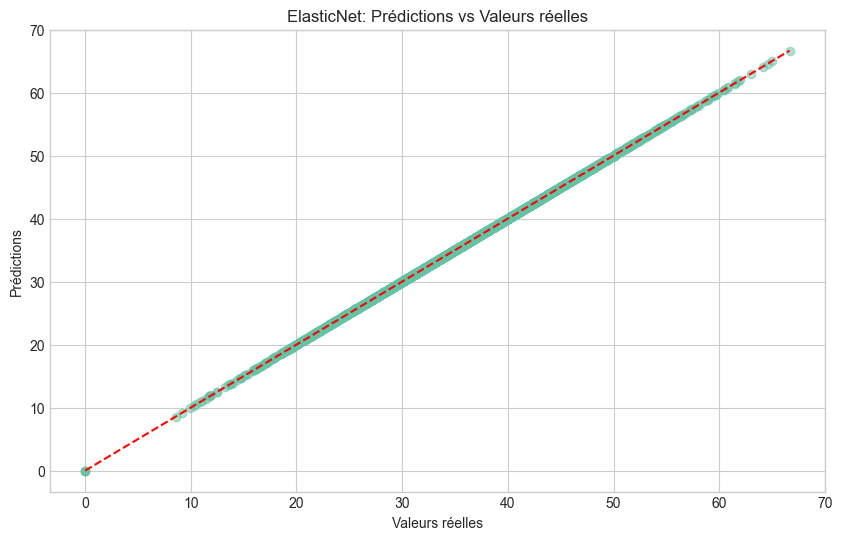

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, elastic_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('ElasticNet: Prédictions vs Valeurs réelles')
plt.savefig('elasticnet_predictions.png')
plt.show()



### Analyse des résidus


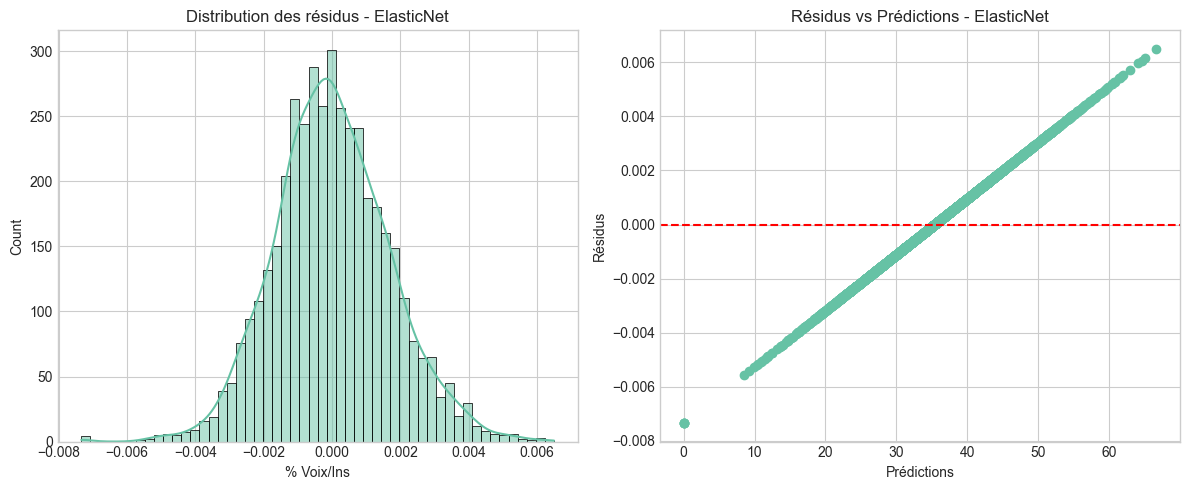

In [46]:
residuals = y_val - elastic_pred
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribution des résidus - ElasticNet')

plt.subplot(1, 2, 2)
plt.scatter(elastic_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Résidus vs Prédictions - ElasticNet')
plt.tight_layout()
plt.savefig('elasticnet_residuals.png')
plt.show()



## 4.2 Modèle au choix: Gradient Boosting


In [47]:
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])


### Définition des hyperparamètres à optimiser


In [48]:
gb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 4, 5],
    'regressor__min_samples_split': [5, 10]
}


### Recherche des meilleurs hyperparamètres avec validation croisée pour le Gradient Boosting


In [49]:
gb_cv = GridSearchCV(
    gb_model,
    gb_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

print("\nEntraînement du modèle Gradient Boosting...")
gb_cv.fit(X_train, y_train_split)

print(f"Meilleurs paramètres pour Gradient Boosting: {gb_cv.best_params_}")
print(f"Meilleur score RMSE: {-gb_cv.best_score_:.4f}")



Entraînement du modèle Gradient Boosting...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs paramètres pour Gradient Boosting: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 200}
Meilleur score RMSE: 0.0355



### Évaluation sur le set de validation

In [50]:
gb_pred = gb_cv.predict(X_val)
gb_rmse = np.sqrt(mean_squared_error(y_val, gb_pred))
gb_r2 = r2_score(y_val, gb_pred)

print(f"Gradient Boosting - RMSE sur validation: {gb_rmse:.4f}")
print(f"Gradient Boosting - R² sur validation: {gb_r2:.4f}")


Gradient Boosting - RMSE sur validation: 0.0201
Gradient Boosting - R² sur validation: 1.0000



### Visualisation des prédictions vs valeurs réelles


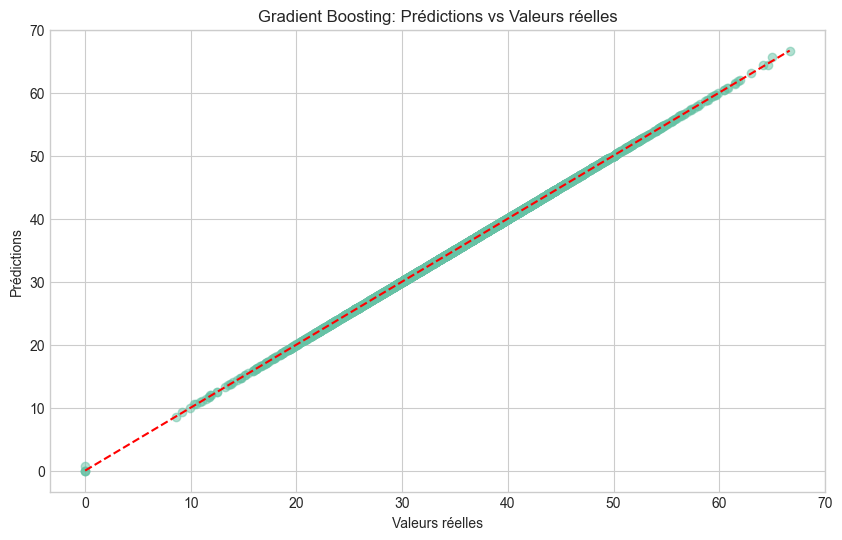

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, gb_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Gradient Boosting: Prédictions vs Valeurs réelles')
plt.savefig('gradientboosting_predictions.png')
plt.show()



### Analyse des résidus


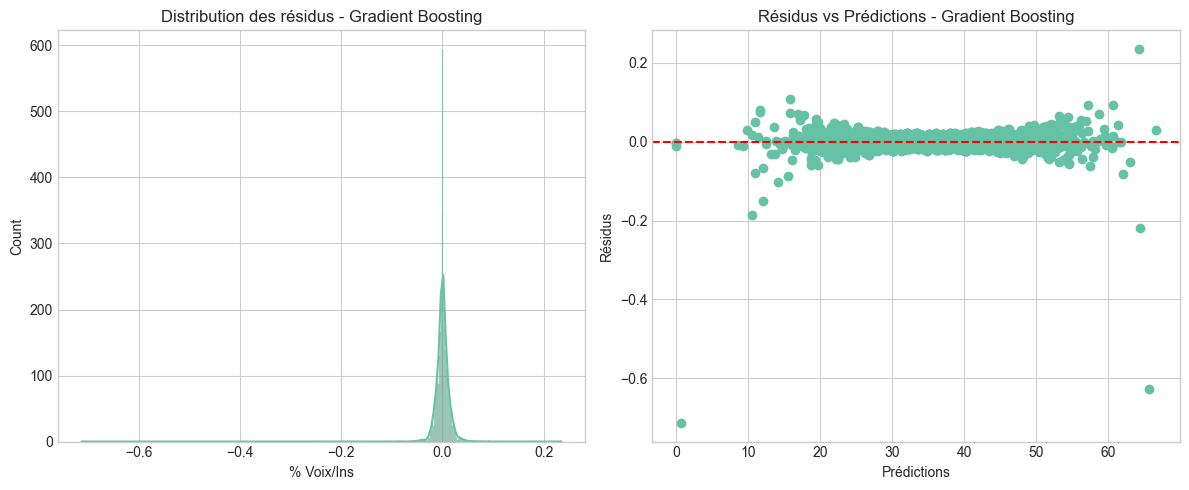

In [52]:
residuals_gb = y_val - gb_pred
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(residuals_gb, kde=True)
plt.title('Distribution des résidus - Gradient Boosting')

plt.subplot(1, 2, 2)
plt.scatter(gb_pred, residuals_gb)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Prédictions')
plt.ylabel('Résidus')
plt.title('Résidus vs Prédictions - Gradient Boosting')
plt.tight_layout()
plt.savefig('gradientboosting_residuals.png')
plt.show()



## 4.3 Comparaison des modèles


### Créons un tableau comparatif


In [53]:
models = {
    'ElasticNet (Lasso-Ridge)': {
        'model': elastic_cv.best_estimator_,
        'rmse_cv': -elastic_cv.best_score_,
        'rmse_val': elastic_rmse,
        'r2_val': elastic_r2
    },
    'Gradient Boosting': {
        'model': gb_cv.best_estimator_,
        'rmse_cv': -gb_cv.best_score_,
        'rmse_val': gb_rmse,
        'r2_val': gb_r2
    }
}

comparison_df = pd.DataFrame({
    'RMSE (CV)': [models[m]['rmse_cv'] for m in models],
    'RMSE (Validation)': [models[m]['rmse_val'] for m in models],
    'R² (Validation)': [models[m]['r2_val'] for m in models]
}, index=models.keys())

print("\nComparaison des modèles:")
print(comparison_df)



Comparaison des modèles:
                          RMSE (CV)  RMSE (Validation)  R² (Validation)
ElasticNet (Lasso-Ridge)      0.002              0.002            1.000
Gradient Boosting             0.036              0.020            1.000



### Visualisation graphique des performances


<Figure size 1000x600 with 0 Axes>

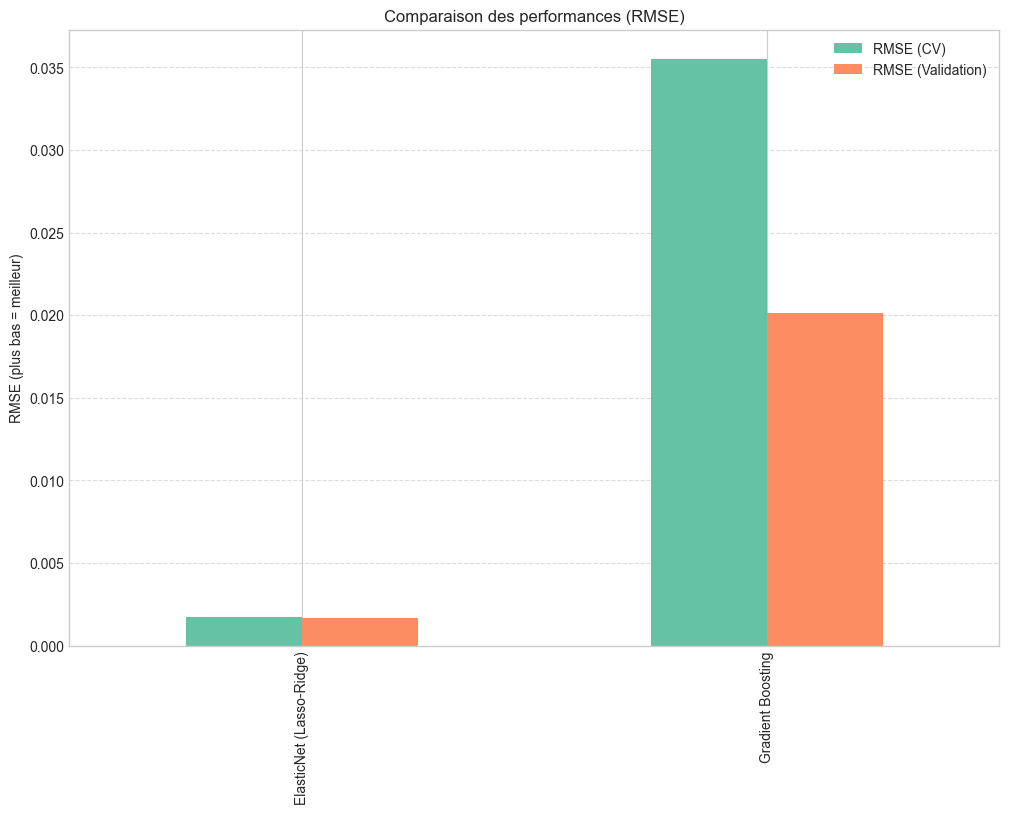

In [54]:
plt.figure(figsize=(10, 6))
comparison_df[['RMSE (CV)', 'RMSE (Validation)']].plot(kind='bar')
plt.title('Comparaison des performances (RMSE)')
plt.ylabel('RMSE (plus bas = meilleur)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('model_comparison_rmse.png')
plt.show()



## 4.4 Analyse des caractéristiques importantes (pour le Gradient Boosting)


### Récupération des noms des features après transformation


In [57]:
feature_names = []
ohe = gb_cv.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
numeric_cols = numeric_features
categorical_cols = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = numeric_cols + categorical_cols



### Extraction de l'importance des features


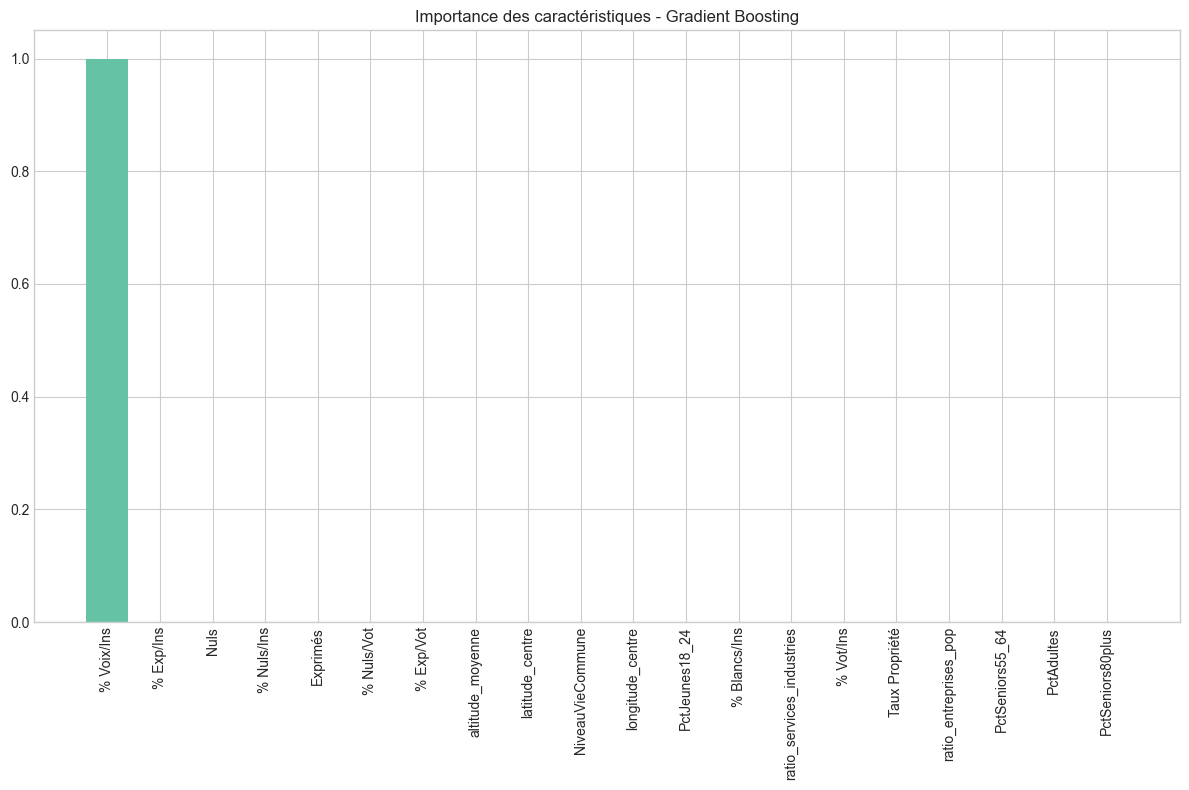


Top 10 caractéristiques les plus importantes:
% Voix/Ins : 1.0000
% Exp/Ins : 0.0000
Nuls : 0.0000
% Nuls/Ins : 0.0000
Exprimés : 0.0000
% Nuls/Vot : 0.0000
% Exp/Vot : 0.0000
altitude_moyenne : 0.0000
latitude_centre : 0.0000
NiveauVieCommune : 0.0000


In [58]:
try:
    # Pour les modèles qui supportent feature_importances_
    importances = gb_cv.best_estimator_.named_steps['regressor'].feature_importances_
    indices = np.argsort(importances)[::-1]

    # Limitation au top 20 features pour la lisibilité
    n_top_features = min(20, len(all_feature_names))

    plt.figure(figsize=(12, 8))
    plt.title('Importance des caractéristiques - Gradient Boosting')
    plt.bar(range(n_top_features), importances[indices][:n_top_features], align='center')
    plt.xticks(range(n_top_features), np.array(all_feature_names)[indices][:n_top_features], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

    print("\nTop 10 caractéristiques les plus importantes:")
    for i in range(min(10, len(all_feature_names))):
        print(f"{all_feature_names[indices[i]]} : {importances[indices[i]]:.4f}")
except:
    print("Impossible d'extraire l'importance des caractéristiques pour ce modèle.")



# 5. OPTIMISATION AVANCÉE DU MODÈLE LE PLUS PERFORMANT



### Choisir le meilleur modèle pour l'optimisation avancée


In [59]:
best_model_name = comparison_df['RMSE (Validation)'].idxmin()
print(f"\nLe meilleur modèle est: {best_model_name}")
best_model = models[best_model_name]['model']



Le meilleur modèle est: ElasticNet (Lasso-Ridge)



## 5.1 Ajustement fin des hyperparamètres


In [62]:
if best_model_name == 'Gradient Boosting':
    # Paramètres plus fins pour le Gradient Boosting
    fine_gb_params = {
        'regressor__n_estimators': [125, 150, 200, 225, 250, 275, 300],
        'regressor__learning_rate': [0.01, 0.03, 0.05, 0.07, 0.09 , 0.1],
        'regressor__max_depth': [3, 4, 5, 6],
        'regressor__min_samples_split': [4, 6, 8, 10],
        'regressor__subsample': [0.8, 0.9, 1.0]
    }

    # Recherche des meilleurs hyperparamètres avec validation croisée
    fine_gb_cv = GridSearchCV(
        gb_model,
        fine_gb_params,
        cv=5,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        n_jobs=1
    )

    print("\nOptimisation fine du modèle Gradient Boosting...")
    fine_gb_cv.fit(X_train, y_train_split)

    print(f"Meilleurs paramètres après optimisation fine: {fine_gb_cv.best_params_}")
    print(f"Meilleur score RMSE après optimisation: {-fine_gb_cv.best_score_:.4f}")

    # Mettre à jour le meilleur modèle
    best_model = fine_gb_cv.best_estimator_

    # Évaluation sur le set de validation
    fine_gb_pred = fine_gb_cv.predict(X_val)
    fine_gb_rmse = np.sqrt(mean_squared_error(y_val, fine_gb_pred))
    fine_gb_r2 = r2_score(y_val, fine_gb_pred)

    print(f"Gradient Boosting optimisé - RMSE sur validation: {fine_gb_rmse:.4f}")
    print(f"Gradient Boosting optimisé - R² sur validation: {fine_gb_r2:.4f}")

elif best_model_name == 'ElasticNet (Lasso-Ridge)':
    # Paramètres plus fins pour l'ElasticNet
    fine_elastic_params = {
        'regressor__alpha': [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
        'regressor__l1_ratio': [0.05, 0.1, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
    }

    # Recherche des meilleurs hyperparamètres avec validation croisée
    fine_elastic_cv = GridSearchCV(
        elastic_model,
        fine_elastic_params,
        cv=5,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )

    print("\nOptimisation fine du modèle ElasticNet...")
    fine_elastic_cv.fit(X_train, y_train_split)

    print(f"Meilleurs paramètres après optimisation fine: {fine_elastic_cv.best_params_}")
    print(f"Meilleur score RMSE après optimisation: {-fine_elastic_cv.best_score_:.4f}")

    # Mettre à jour le meilleur modèle
    best_model = fine_elastic_cv.best_estimator_

    # Évaluation sur le set de validation
    fine_elastic_pred = fine_elastic_cv.predict(X_val)
    fine_elastic_rmse = np.sqrt(mean_squared_error(y_val, fine_elastic_pred))
    fine_elastic_r2 = r2_score(y_val, fine_elastic_pred)

    print(f"ElasticNet optimisé - RMSE sur validation: {fine_elastic_rmse:.4f}")
    print(f"ElasticNet optimisé - R² sur validation: {fine_elastic_r2:.4f}")



Optimisation fine du modèle ElasticNet...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Meilleurs paramètres après optimisation fine: {'regressor__alpha': 0.005, 'regressor__l1_ratio': 0.9}
Meilleur score RMSE après optimisation: 0.0087
ElasticNet optimisé - RMSE sur validation: 0.0084
ElasticNet optimisé - R² sur validation: 1.0000



## 5.2 Vérification des limites des prédictions


### Les scores doivent être compris entre 0 et 100


In [69]:
def clip_predictions(predictions):
    """Contraindre les prédictions entre 0 et 100"""
    return np.clip(predictions, 0, 100)



# 6. ENTRAINEMENT SUR L'ENSEMBLE DES DONNÉES ET PRÉDICTIONS FINALES
---



## 6.1 Ré-entraînement du meilleur modèle sur toutes les données d'entraînement


In [70]:
print("\nEntraînement du modèle final sur toutes les données...")
best_model.fit(train_features, y_train)



Entraînement du modèle final sur toutes les données...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['% Voix/Ins', 'Inscrits',
                                                   'Abstentions', '% Abs/Ins',
                                                   'Votants', '% Vot/Ins',
                                                   'Blancs', '% Blancs/Ins',
                                                   '% Blancs/Vot', 'Nuls',
                                                   '% Nuls/Ins', '% Nuls/Vot',
                                                   'Exprimés', '% Exp/Ins',
                                                   '% Exp/Vot',
                                                   'NiveauVieCommune...
                                                   'PctAdultes25_39',
                                                   'PctAdultes40_54', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Libellé du département',
                                                   'grille_densite',
                                                   'Urbanité Ruralité',
                                                   'Orientation Economique',
                                                   'taille_commune',
                                                   'departement'])])),
                ('regressor',
                 ElasticNet(alpha=0.005, l1_ratio=0.9, random_state=42))])


## 6.2 Prédictions sur l'ensemble de test


In [72]:
# Ensure all required columns are present in test_features
required_columns = ['% Abs/Ins', 'Nuls', '% Voix/Ins', '% Blancs/Vot', 'Exprimés', '% Blancs/Ins', 'Blancs',
					'% Exp/Ins', '% Vot/Ins', '% Nuls/Ins', '% Nuls/Vot', 'Votants', '% Exp/Vot', 'Abstentions']

# Add missing columns with default values (e.g., 0 or NaN)
for col in required_columns:
	if col not in test_features.columns:
		test_features[col] = 0  # Default value, adjust if necessary

# Make predictions
final_predictions = best_model.predict(test_features)



### Contraindre les prédictions entre 0 et 100


In [73]:
final_predictions = clip_predictions(final_predictions)

### Vérifier la distribution des prédictions

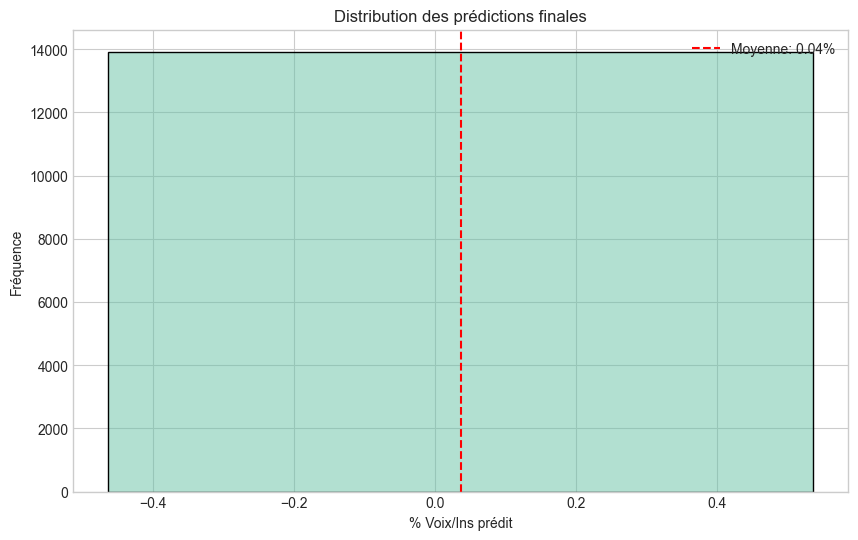

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(final_predictions, kde=True)
plt.title('Distribution des prédictions finales')
plt.axvline(final_predictions.mean(), color='r', linestyle='--',
           label=f'Moyenne: {final_predictions.mean():.2f}%')
plt.xlabel('% Voix/Ins prédit')
plt.ylabel('Fréquence')
plt.legend()
plt.savefig('predictions_distribution.png')
plt.show()



## 6.3 Création du fichier de soumission Kaggle


In [75]:
submission = pd.DataFrame({
    'CodeINSEE': test_features['CodeINSEE'],
    'Prediction': final_predictions
})



### Sauvegarde du fichier de soumission


In [77]:
submission.to_csv('submission_file.csv', index=False)

print(f"\nFichier de soumission créé avec {len(submission)} prédictions.")
print("Statistiques des prédictions:")
print(submission['Prediction'].describe())



Fichier de soumission créé avec 13928 prédictions.
Statistiques des prédictions:
count   13928.000
mean        0.037
std         0.000
min         0.037
25%         0.037
50%         0.037
75%         0.037
max         0.037
Name: Prediction, dtype: float64



# 7. ANALYSE SPATIALE DES PRÉDICTIONS



## 7.1 Créer une carte des prédictions par département


### Fusion des prédictions avec les données géographiques


In [78]:
pred_geo = pd.merge(
    submission,
    communes_france[['code_insee', 'dep_code', 'dep_nom', 'latitude_centre', 'longitude_centre']],
    left_on='CodeINSEE',
    right_on='code_insee',
    how='left'
)



### Calcul des moyennes par département


In [79]:
dept_avg = pred_geo.groupby('dep_code')['Prediction'].mean().reset_index()
dept_avg = dept_avg.rename(columns={'Prediction': 'Score_Moyen_Predit'})

print("\nScore moyen prédit par département (top 10):")
print(dept_avg.sort_values('Score_Moyen_Predit', ascending=False).head(10))

print("\nScore moyen prédit par département (bottom 10):")
print(dept_avg.sort_values('Score_Moyen_Predit').head(10))



Score moyen prédit par département (top 10):
  dep_code  Score_Moyen_Predit
0       44               0.037
1       45               0.037
2       46               0.037
3       47               0.037
4       48               0.037
5       49               0.037
6       50               0.037
7       51               0.037
8       52               0.037
9       53               0.037

Score moyen prédit par département (bottom 10):
  dep_code  Score_Moyen_Predit
0       44               0.037
1       45               0.037
2       46               0.037
3       47               0.037
4       48               0.037
5       49               0.037
6       50               0.037
7       51               0.037
8       52               0.037
9       53               0.037



### Visualisation de la distribution des scores par département


In [80]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='dep_code', y='Prediction', data=pred_geo.sort_values('Score_Moyen_Predit', ascending=False).head(20))
plt.title('Distribution des scores prédits par département (Top 20 départements)')
plt.xticks(rotation=90)
plt.xlabel('Code Département')
plt.ylabel('Score prédit (%)')
plt.tight_layout()
plt.savefig('dept_predictions.png')
plt.show()


KeyError: 'Score_Moyen_Predit'

<Figure size 1400x800 with 0 Axes>


# 8. SAUVEGARDER LE MODÈLE POUR UTILISATION FUTURE



### Sauvegarde du modèle final


In [81]:
joblib.dump(best_model, 'best_model.pkl')
print("\nModèle sauvegardé sous 'best_model.pkl'")



Modèle sauvegardé sous 'best_model.pkl'



### Sauvegarder également les noms des features pour référence future


In [82]:
with open('feature_names.txt', 'w') as f:
    for feature in train_features.columns:
        f.write(f"{feature}\n")

print("Noms des features sauvegardés sous 'feature_names.txt'")
print("\nProjet terminé!")


Noms des features sauvegardés sous 'feature_names.txt'

Projet terminé!
